# Ablation

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

import precomputed
from ODE import *
from NN_setup import *

# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available, training on:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

ModuleNotFoundError: No module named 'precomputed'

In [39]:
# NOTE: modified train_and_test
def train_and_test(model, train_loader, test_loader, optimizer = "Adam", num_epochs = 1):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam (model.parameters(), lr=0.01)
    
    epoch_train_loss_list_mean_per_simulation = []
    overall_train_loss_list_one_value_per_epoch = []
    overall_test_loss_list_one_value_per_epoch = []
    full_train_loss = [] # added
    j = 0
    start_time = time.time()  
    for epoch in range (num_epochs):
        epoch = epoch + 1
        model.train()
        
        for n, data in enumerate (train_loader):
            # print("n:", n, "data shape:", data.shape, "data.shape[1]:", data.shape[1])
            train_loss_list_per_simulation = []
            for i in range(data.shape[1]-1):
                # print("i:", i)

                prev_4_states = data[0, i, :-1].float().flatten().to(device)
                # print("prev_4_states size", prev_4_states.size())

                current_temp = data[0, i, -1].float().flatten().to(device)
                # print("current_state size", current_temp.size())
                
                predicted_current_temp = model(prev_4_states) # (1,)
                loss = loss_func (current_temp, predicted_current_temp)
                train_loss_list_per_simulation.append (loss.item())
                full_train_loss.append (loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                j+=1
                # if j % 1000 == 0:
                    # print(f"Global iterations {j} | loss = {loss}")
            epoch_train_loss_list_mean_per_simulation.append(np.mean(train_loss_list_per_simulation))
            
        if epoch % 1 == 0:
            print(f"Epoch {epoch} | Epoch mean training loss for a single simulation = {np.mean(epoch_train_loss_list_mean_per_simulation)}")
        overall_train_loss_list_one_value_per_epoch.append(np.mean(epoch_train_loss_list_mean_per_simulation))
        epoch_test_loss_list_mean_per_simulation = []
        
        model = model.eval()
        
        test_loss = 0
        with torch.no_grad():
            for n, data in enumerate (test_loader):
                # print("n:", n, "data shape:", data.shape, "data.shape[1]:", data.shape[1])
                model_output = []
                ground_truth = []
                test_loss_list_per_simulation = []
                for i in range(data.shape[1]-1):
                    # print("i:", i)

                    prev_4_states = data[0, i, :-1].float().flatten().to(device)
                    # print("prev_4_states size", prev_4_states.size())

                    current_temp = data[0, i, -1].float().flatten().to(device)
                    # print("current_state size", current_temp.size())
                    
                    predicted_current_temp = model(prev_4_states) # (1,)

                    model_output.append (predicted_current_temp.item()-273.15)
                    ground_truth.append (current_temp[0].item()-273.15)
                    # print("predicted_current_temp:", predicted_current_temp.item(), "ground_truth:", current_temp[0].item())
                    
                    loss = loss_func (current_temp, predicted_current_temp)
                    test_loss_list_per_simulation.append(loss.item())                
                # Checking for best model output 
                if np.mean(test_loss_list_per_simulation) < min(epoch_test_loss_list_mean_per_simulation):
                    best_this_epoch_model_output = model_output
                    best_this_epoch_ground_truth = ground_truth
                    best_this_epoch_simulation_accuracy = np.mean(test_loss_list_per_simulation)
                # Checking for worst model output 
                if np.mean(test_loss_list_per_simulation) < max(epoch_test_loss_list_mean_per_simulation):
                    worst_this_epoch_model_output = model_output
                    worst_this_epoch_ground_truth = ground_truth
                    worst_this_epoch_simulation_accuracy = np.mean(test_loss_list_per_simulation)
                epoch_test_loss_list_mean_per_simulation.append(np.mean(test_loss_list_per_simulation))

        print(f"Epoch {epoch} | Epoch mean test loss for a single simulation = {np.mean(epoch_test_loss_list_mean_per_simulation)}")
        if np.mean(epoch_test_loss_list_mean_per_simulation) < min(overall_test_loss_list_one_value_per_epoch):
            best_epoch = epoch
            best_epoch_test_loss = np.mean(epoch_test_loss_list_mean_per_simulation)
            best_model_output = best_this_epoch_model_output
            best_ground_truth = best_this_epoch_ground_truth
            best_simulation_accuracy = best_this_epoch_simulation_accuracy
            worst_model_output = worst_this_epoch_model_output
            worst_ground_truth = worst_this_epoch_ground_truth
            worst_simulation_accuracy = worst_this_epoch_simulation_accuracy
        overall_test_loss_list_one_value_per_epoch.append(np.mean(epoch_test_loss_list_mean_per_simulation))
    print("The model's best epoch was", best_epoch, "with a test loss of", best_epoch_test_loss)
    print("The model's best simulation accuracy in that epoch was", best_simulation_accuracy)
    print("The model's worst simulation accuracy in that epoch was", worst_simulation_accuracy)
    # Generate best plot sample for each model
    pred_error = []
    for i in range(len(best_model_output)):
        pred_error.append(best_ground_truth[i] - best_model_output[i])
    plt.plot(pred_error)
    plt.title(f"Prediction error (ground truth - prediction) for set n = {epoch}")
    plt.xlabel("Timesteps")
    plt.ylabel("Error")
    plt.show();

    # Plot model output and ground truth
    plt.plot(best_ground_truth, label = "Ground Truth")
    plt.plot(best_model_output, label = "Model Output")
    plt.title(f"Model Output vs Ground Truth for set n = {epoch}")
    plt.xlabel("Timesteps")
    plt.ylabel("Temperature (C)")
    plt.legend()
    plt.show();
    # Generate worst plot sample for each model
    pred_error = []
    for i in range(len(worst_model_output)):
        pred_error.append(worst_ground_truth[i] - worst_model_output[i])
    plt.plot(pred_error)
    plt.title(f"Prediction error (ground truth - prediction) for set n = {epoch}")
    plt.xlabel("Timesteps")
    plt.ylabel("Error")
    plt.show();

    # Plot model output and ground truth
    plt.plot(worst_ground_truth, label = "Ground Truth")
    plt.plot(worst_model_output, label = "Model Output")
    plt.title(f"Model Output vs Ground Truth for set n = {epoch}")
    plt.xlabel("Timesteps")
    plt.ylabel("Temperature (C)")
    plt.legend()
    plt.show();
      
        
    # Plot loss
    plt.plot(overall_train_loss_list_one_value_per_epoch, label = "Train Loss")
    plt.plot(overall_test_loss_list_one_value_per_epoch, label = "Test Loss")
    plt.legend()
    plt.title("Loss Plot")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show();
    # Evaluating time taken
    end_time = time.time() 
    elapsed_time = end_time - start_time          
    print("Time per epoch = ", elapsed_time/num_epochs)
    print("Total time = ", elapsed_time, "sec")

    return overall_test_loss_list_one_value_per_epoch, full_train_loss, elapsed_time, best_epoch_test_loss, best_simulation_accuracy, worst_simulation_accuracy

In [34]:
# loading data from saved folder
solutions = np.load("./saved/100_solutions.npy")
F_ag_array = np.load("./saved/100_F_ag.npy")
test_solutions = np.load("./saved/10test_solutions.npy")
test_F_ag_array = np.load("./saved/10test_F_ag.npy")
num_timesteps = 500

# Concatenating training data before preprocessing
solutions_w_F_ag = np.concatenate((solutions, F_ag_array.reshape(100,1,num_timesteps)), axis=1)

# Preprocessing training data
train_data = data_preprocessing(solutions_w_F_ag, N = 100, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
print("Training data preprocessing done")

# Concatenating test data before preprocessing
test_solutions_w_F_ag = np.concatenate((test_solutions, test_F_ag_array.reshape(10,1,num_timesteps)), axis=1)

# Preprocessing test data
test_data = data_preprocessing(test_solutions_w_F_ag, N = 10, num_timesteps = num_timesteps, batch_size = 1, shuffle = False)
print("Test data preprocessing done")

pre-processing data with N = 100
Training data preprocessing done
pre-processing data with N = 10
Test data preprocessing done


### Number of neurons

Epoch 1 | Epoch mean training loss for a single simulation = 54.749449776789895
Epoch 1 | Epoch mean test loss for a single simulation = 0.14650496711500077


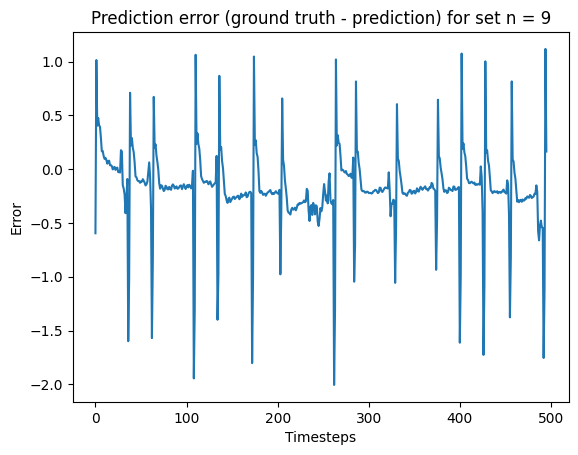

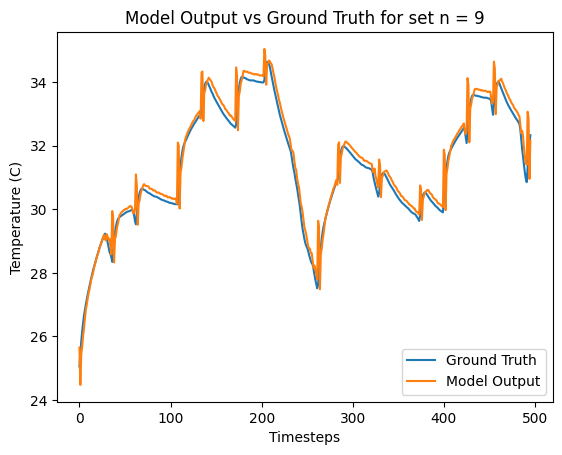

Epoch 2 | Epoch mean training loss for a single simulation = 29.16623465861497
Epoch 2 | Epoch mean test loss for a single simulation = 0.035536654591335044


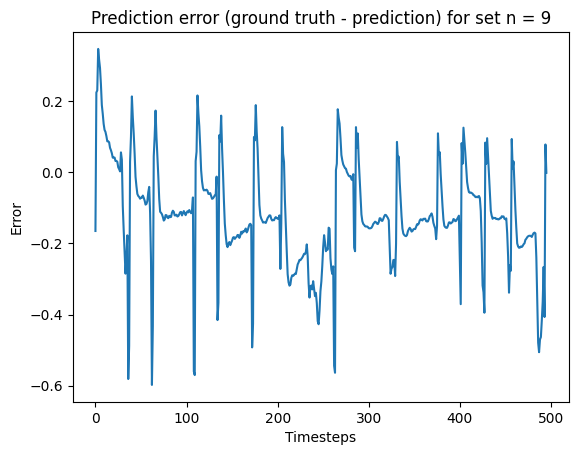

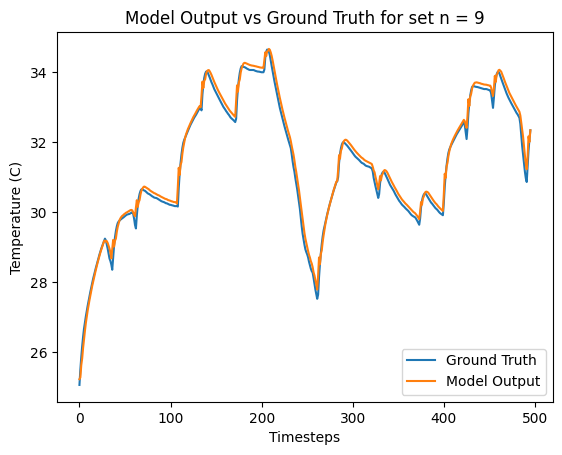

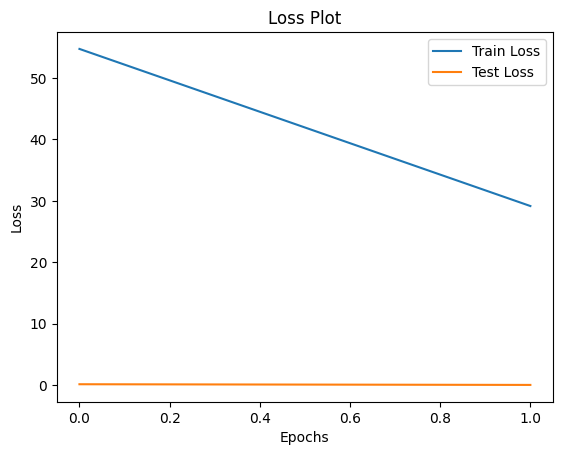

Time per epoch =  102.98398768901825
Total time =  205.9679753780365 sec
train_and_test finished
best_hidden_size: 8


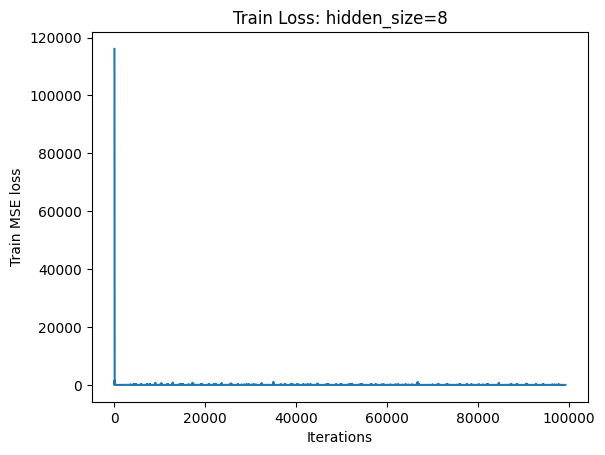

Epoch 1 | Epoch mean training loss for a single simulation = 26.61859125765709
Epoch 1 | Epoch mean test loss for a single simulation = 0.25630586197817584


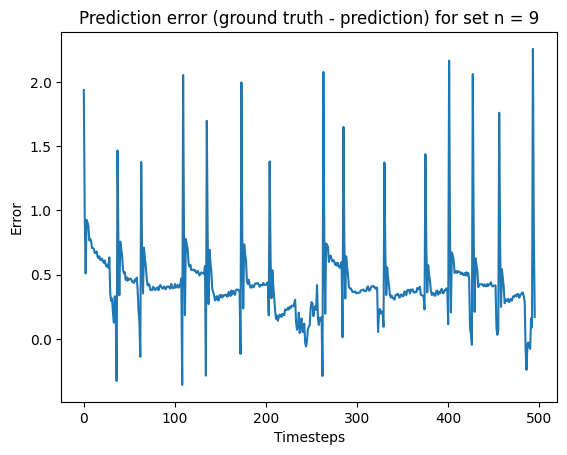

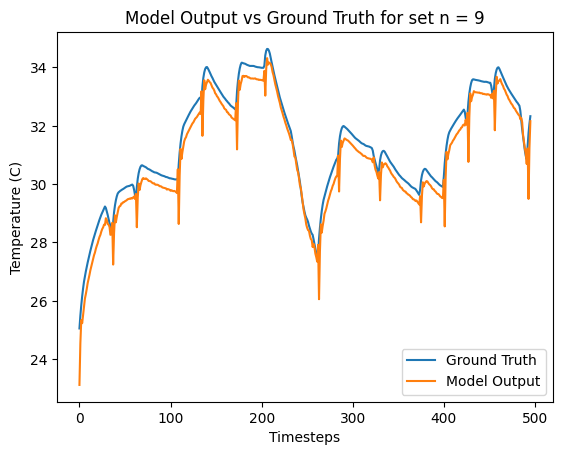

Epoch 2 | Epoch mean training loss for a single simulation = 15.16586489235684
Epoch 2 | Epoch mean test loss for a single simulation = 0.03516117979625931


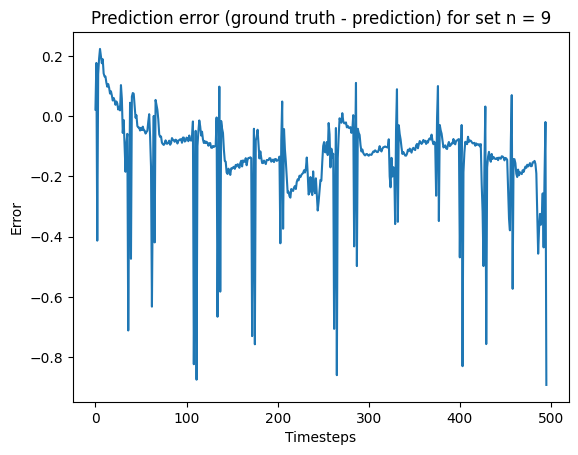

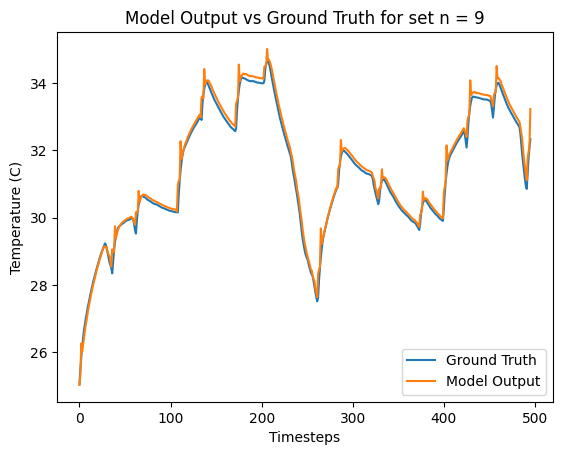

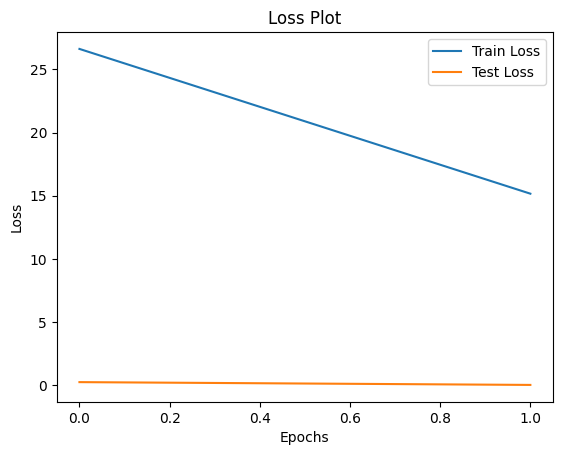

Time per epoch =  102.75657558441162
Total time =  205.51315116882324 sec
train_and_test finished
best_hidden_size: 8


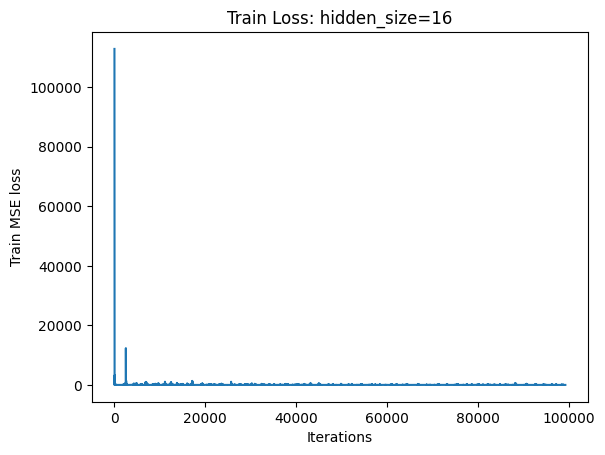

Epoch 1 | Epoch mean training loss for a single simulation = 20.61067100603344
Epoch 1 | Epoch mean test loss for a single simulation = 0.07064709227678607


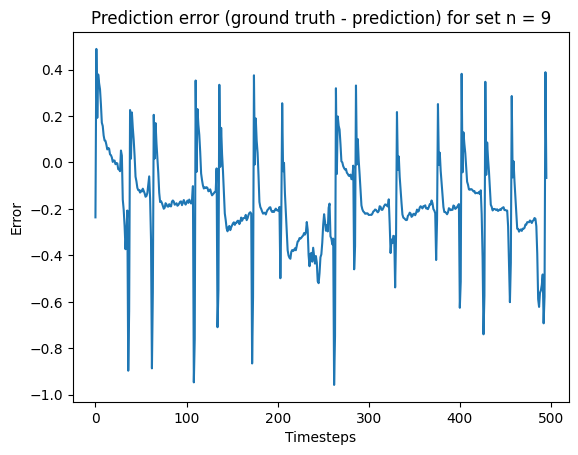

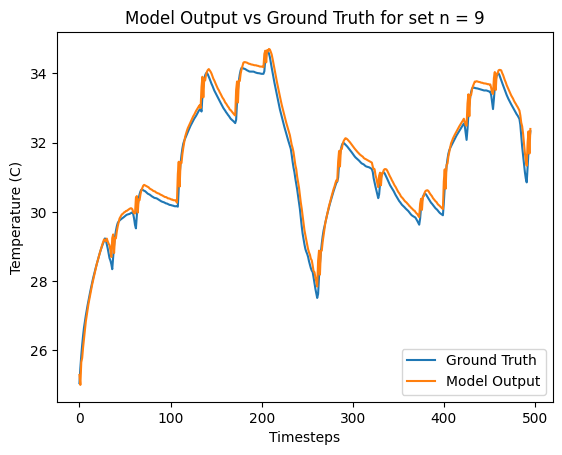

Epoch 2 | Epoch mean training loss for a single simulation = 12.214494463362913
Epoch 2 | Epoch mean test loss for a single simulation = 0.08711707039957775


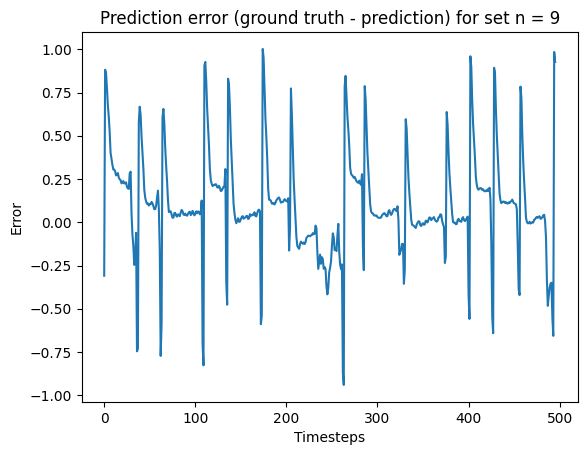

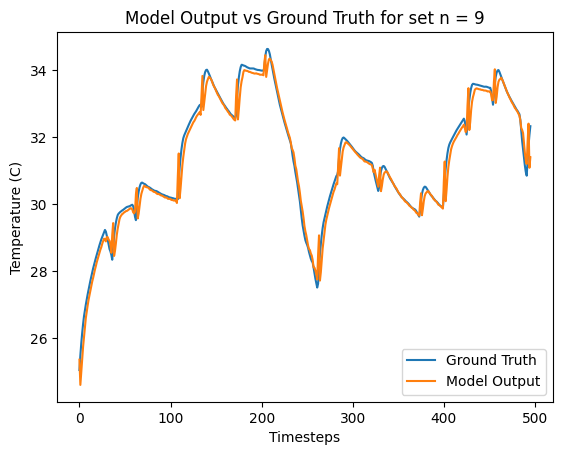

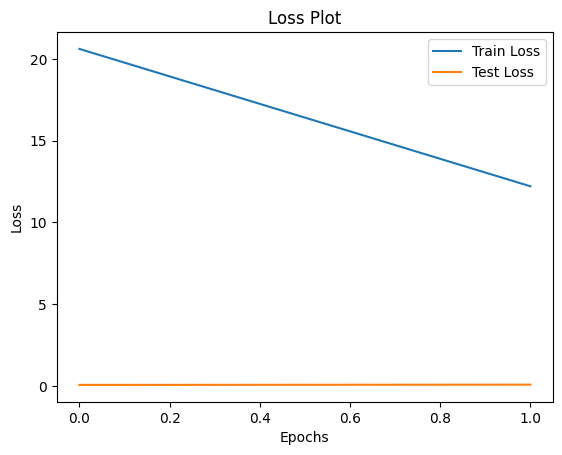

Time per epoch =  103.22899448871613
Total time =  206.45798897743225 sec
train_and_test finished
best_hidden_size: 8


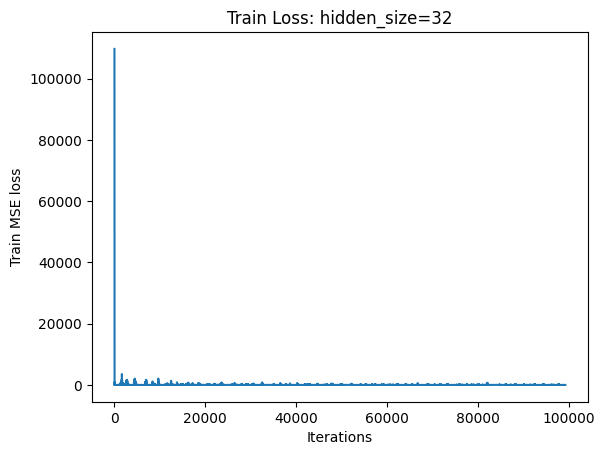

Epoch 1 | Epoch mean training loss for a single simulation = 21.2619614156468
Epoch 1 | Epoch mean test loss for a single simulation = 0.033526223037023885


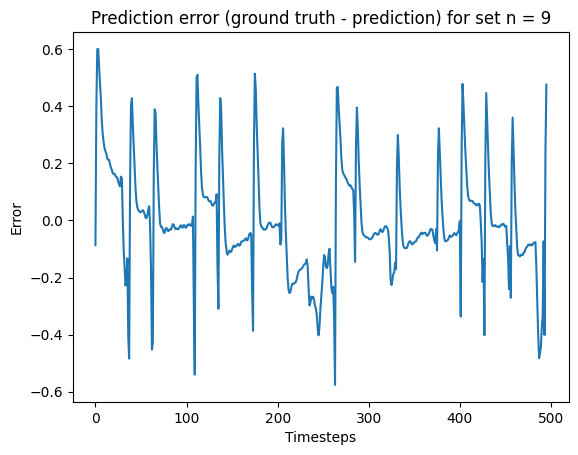

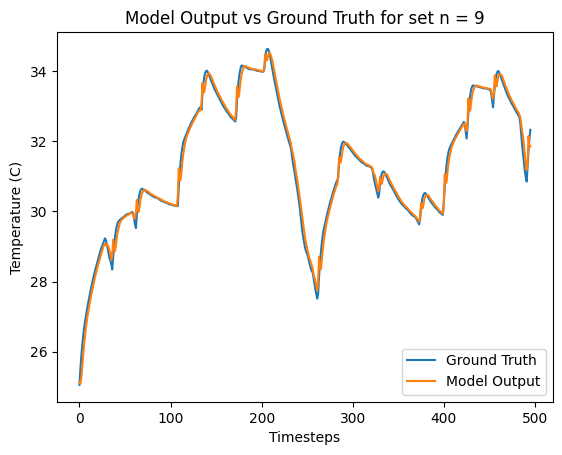

Epoch 2 | Epoch mean training loss for a single simulation = 12.349788622870074
Epoch 2 | Epoch mean test loss for a single simulation = 0.06224696247034796


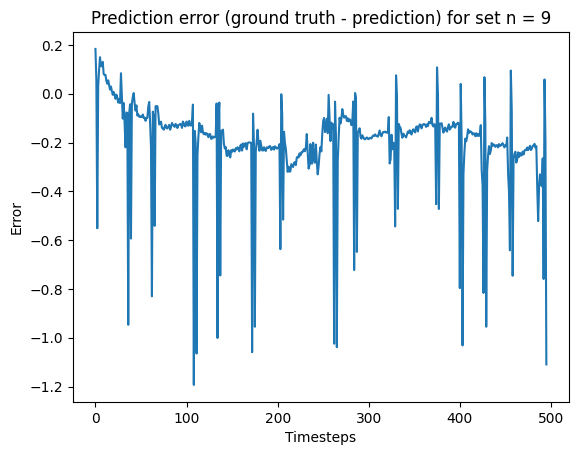

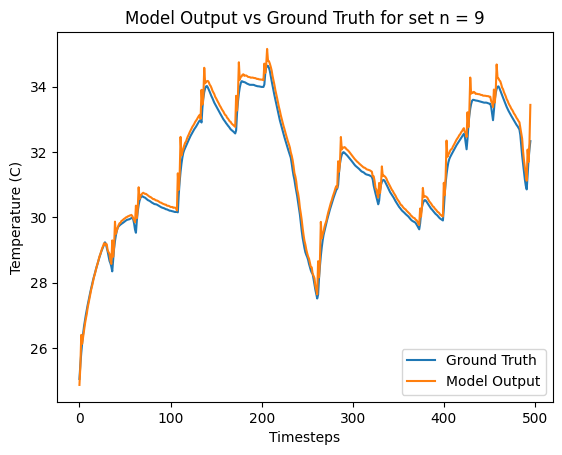

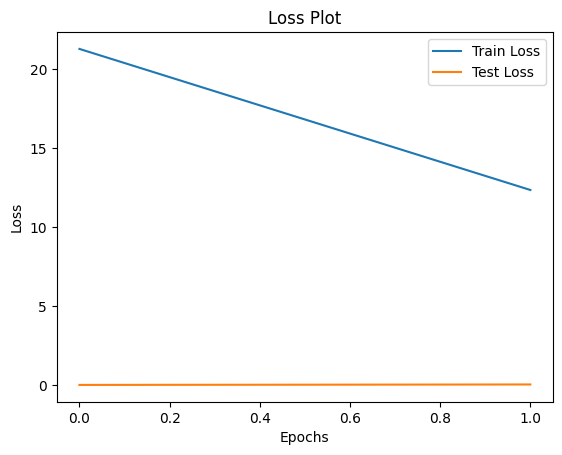

Time per epoch =  103.1240177154541
Total time =  206.2480354309082 sec
train_and_test finished
best_hidden_size: 8


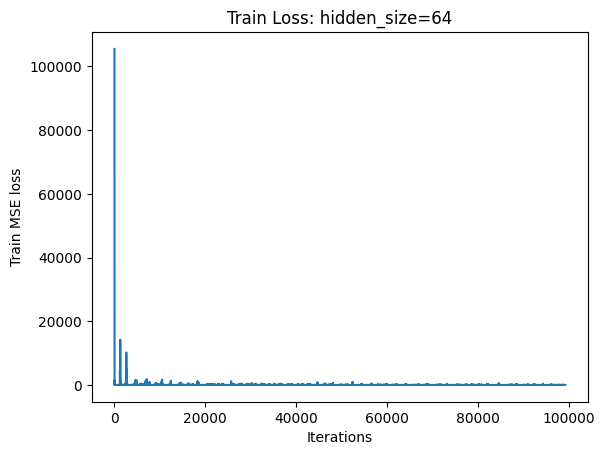

In [40]:

hidden_size_list = [8,16,32,64]
prev_best_loss = np.inf

for hid in hidden_size_list:
    # Initialize the NN (constant input_size8, output_size=1)
    model = NeuralNet (num_hidden_layers = 2, hidden_size = hid, dropout_rate = 0.0, input_size = 8, output_size = 1)

    # Train the NN
    overall_test_loss_list_one_value_per_epoch, train_loss_list, elapsed_time = train_and_test(model, train_data, test_data, optimizer = "Adam", num_epochs = 2)


    # SAVE MODEL
    
    
    if prev_best_loss > train_loss_list[-1]: # if new minimum loss is obtained
        prev_best_loss = train_loss_list[-1] # update minimum loss
        best_model = model                   # set best model
        best_hid = hid

    print ("="*50)
    print ("train_and_test finished")
    print (f"hidden_size: {hid}")
    print ("="*50)

    plt.figure ()
    plt.plot (train_loss_list)
    plt.title(f"Train Loss: hidden_size={hid}")
    plt.xlabel("Iterations")
    plt.ylabel("Train MSE loss")
    plt.show()

print (f"best_hidden_size: {best_hid}")
torch.save(best_model.state_dict(), f"best_hidden_size_{best_hid}.pth")

# SAVE:
# model (state dict)
# overall_test_loss_list_one_value_per_epoch (loss list)
# loss plots
# output plots

### Number of hidden layers

Epoch 1 | Epoch mean training loss for a single simulation = 53.320134340673036
Epoch 1 | Epoch mean test loss for a single simulation = 0.7155651530023709


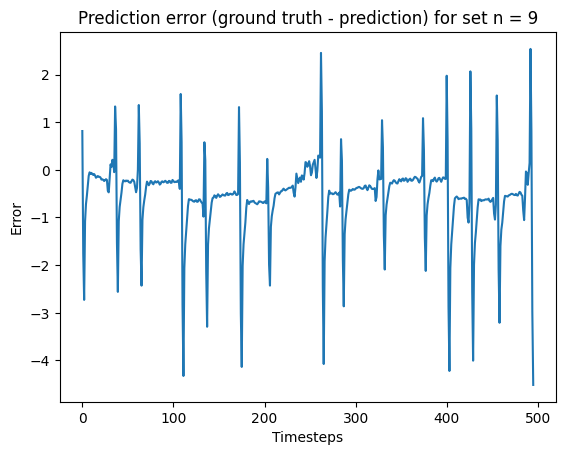

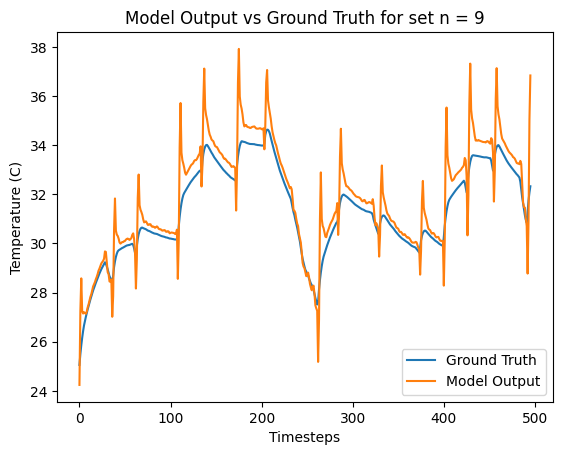

Epoch 2 | Epoch mean training loss for a single simulation = 28.111063633909463
Epoch 2 | Epoch mean test loss for a single simulation = 0.05105697622113381


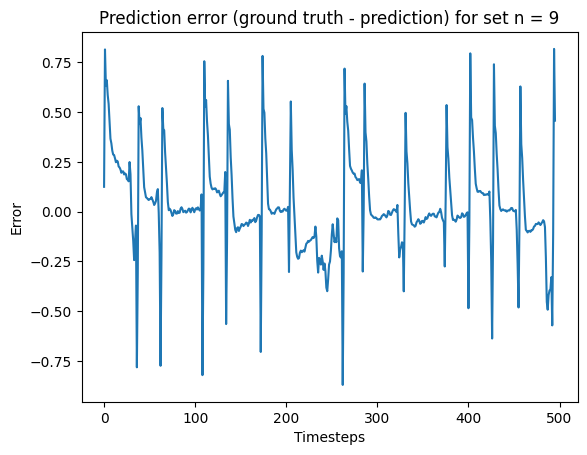

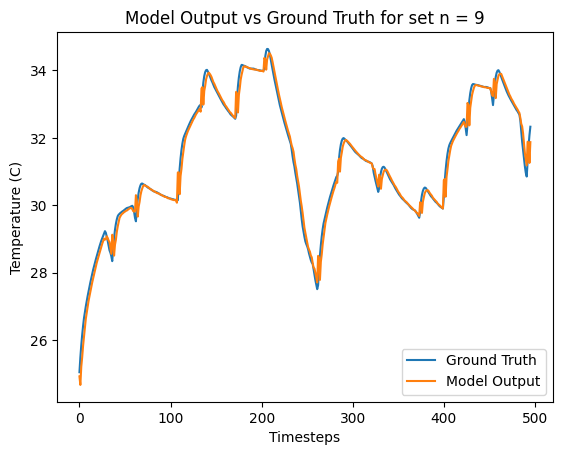

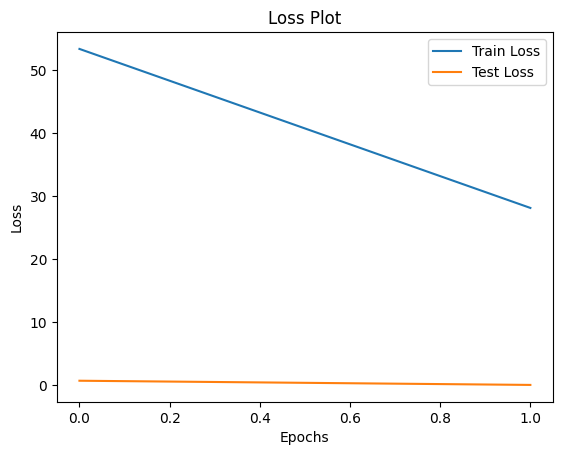

Time per epoch =  83.43549430370331
Total time =  166.87098860740662 sec
train_and_test finished
num_layers: 1


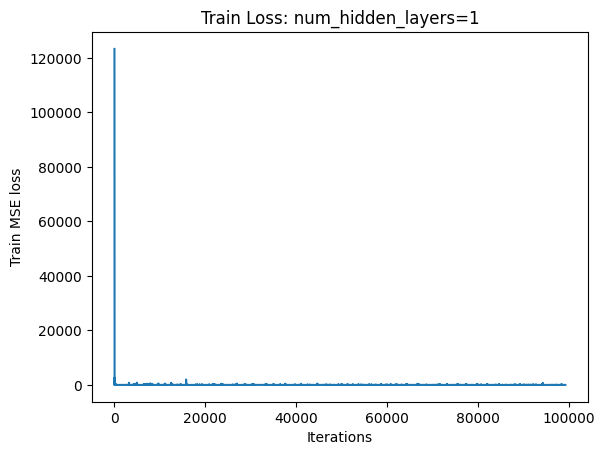

Epoch 1 | Epoch mean training loss for a single simulation = 46.48042844002211
Epoch 1 | Epoch mean test loss for a single simulation = 0.06207358940981419


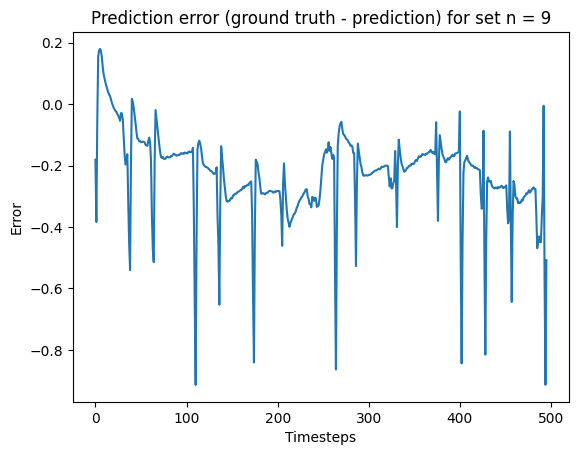

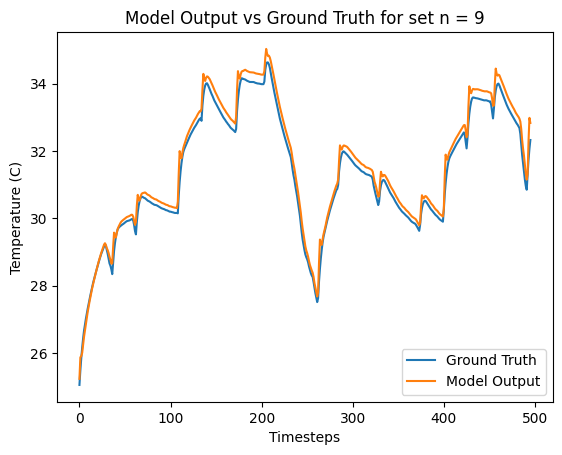

Epoch 2 | Epoch mean training loss for a single simulation = 24.864892289323492
Epoch 2 | Epoch mean test loss for a single simulation = 0.18752622026030066


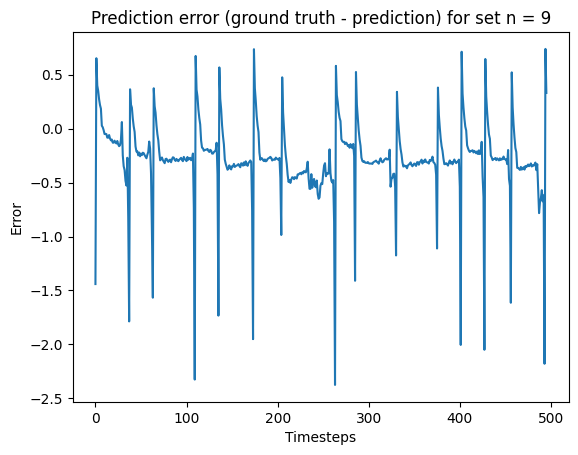

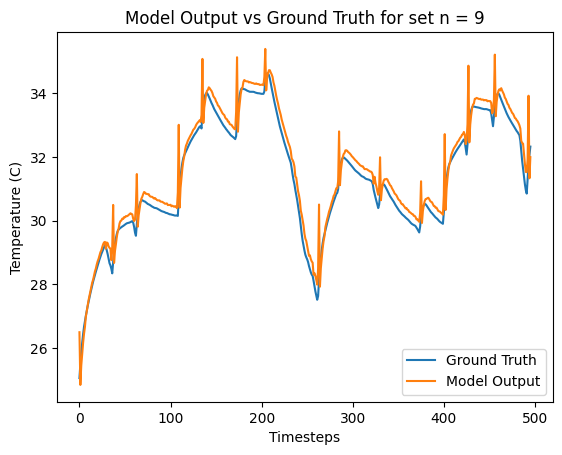

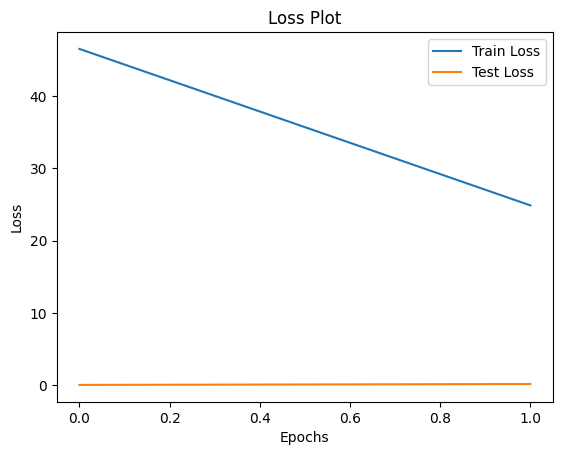

Time per epoch =  101.31716001033783
Total time =  202.63432002067566 sec
train_and_test finished
num_layers: 2


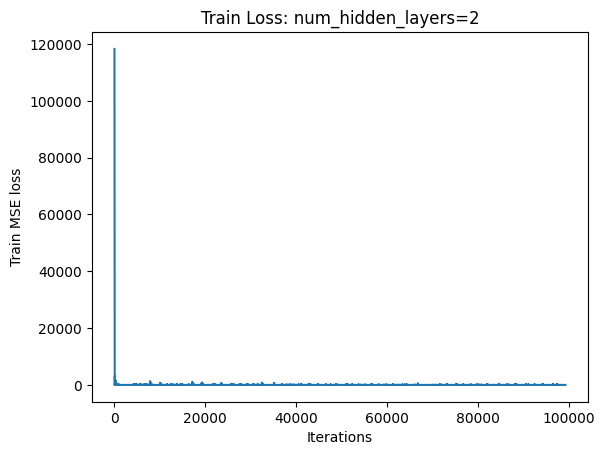

Epoch 1 | Epoch mean training loss for a single simulation = 32.89165880475115
Epoch 1 | Epoch mean test loss for a single simulation = 0.7500936169385715


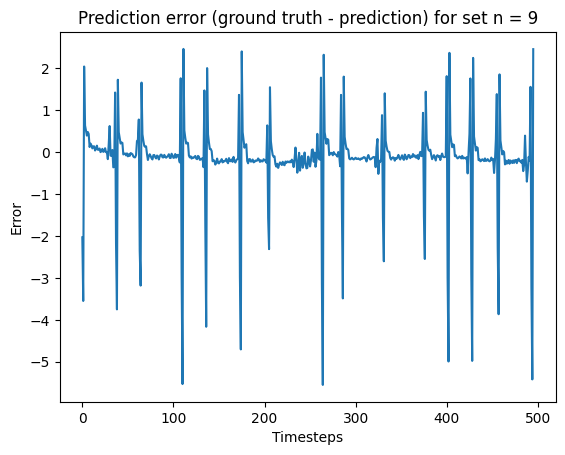

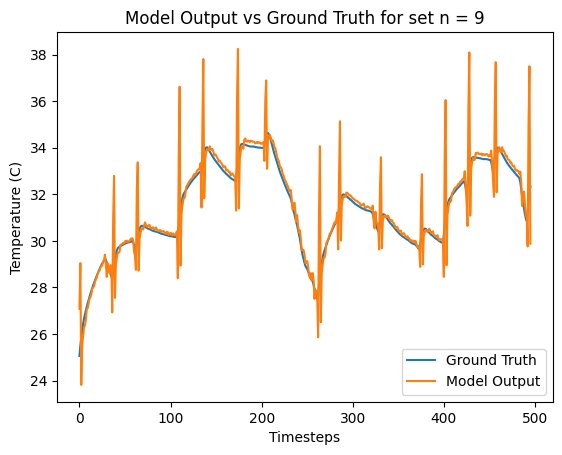

Epoch 2 | Epoch mean training loss for a single simulation = 18.331427579621526
Epoch 2 | Epoch mean test loss for a single simulation = 0.016478135239618323


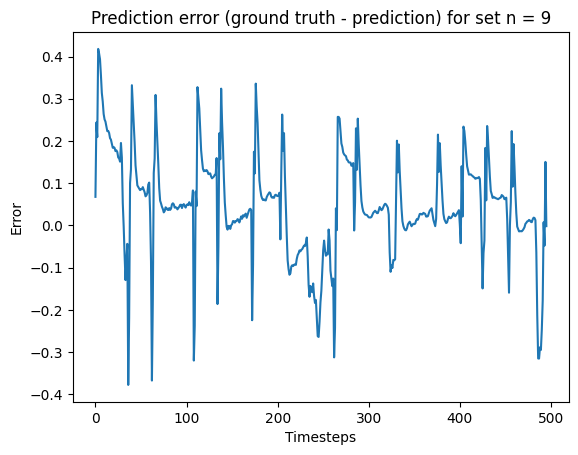

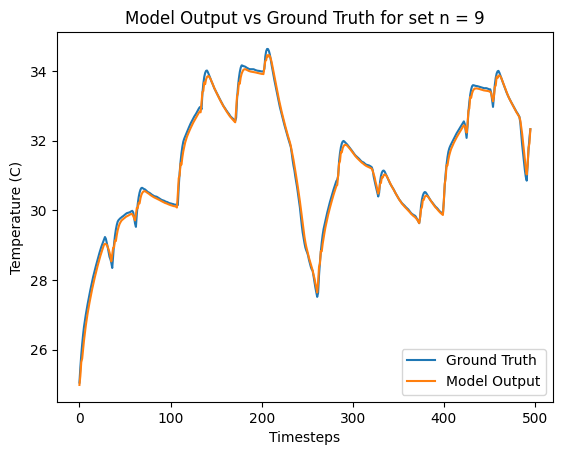

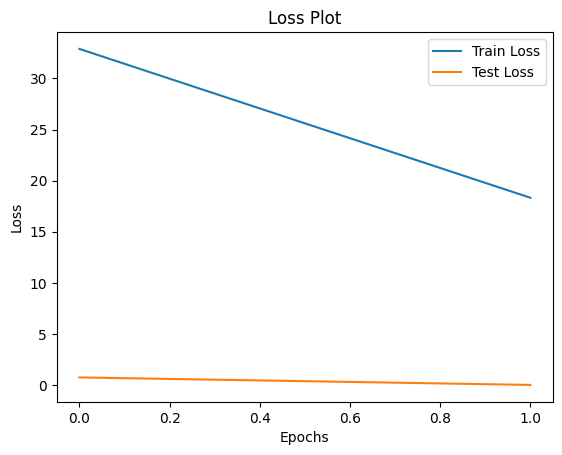

Time per epoch =  115.34052085876465
Total time =  230.6810417175293 sec
train_and_test finished
num_layers: 3


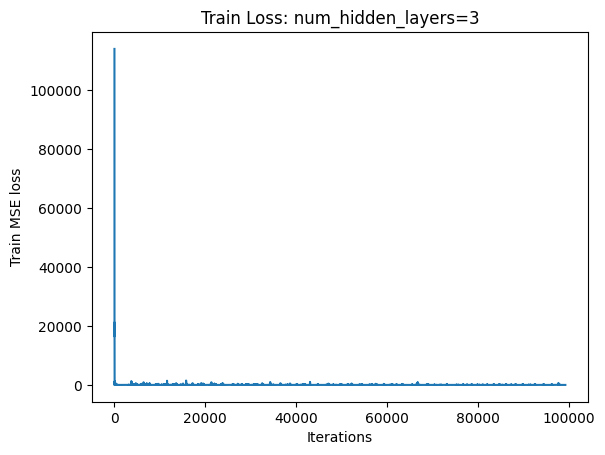

best_num_layers: 3


In [42]:

num_hidden_layers_list = [1,2,3]
prev_best_loss = np.inf

for num_layers in num_hidden_layers_list:
    # Initialize the NN (constant input_size8, output_size=1)
    model = NeuralNet (num_hidden_layers = num_layers, hidden_size = 8, dropout_rate = 0.0, input_size = 8, output_size = 1)

    # Train the NN
    overall_test_loss_list_one_value_per_epoch, train_loss_list, elapsed_time = train_and_test(model, train_data, test_data, optimizer = "Adam", num_epochs = 2)


    # SAVE MODEL
    
    
    if prev_best_loss > train_loss_list[-1]: # if new minimum loss is obtained
        prev_best_loss = train_loss_list[-1] # update minimum loss
        best_model = model                   # set best model
        best_num_layers = num_layers

    print ("="*50)
    print ("train_and_test finished")
    print (f"num_layers: {num_layers}")
    print ("="*50)

    plt.figure ()
    plt.plot (train_loss_list)
    plt.title(f"Train Loss: num_hidden_layers={num_layers}")
    plt.xlabel("Iterations")
    plt.ylabel("Train MSE loss")
    plt.show()

print (f"best_num_layers: {best_num_layers}")
torch.save(best_model.state_dict(), f"best_num_layers_{best_num_layers}.pth")

# SAVE:
# model (state dict)
# overall_test_loss_list_one_value_per_epoch (loss list)
# loss plots
# output plots

### Training with selected best architecture + Dropout:

- Number of neurons in each hidden layer: 8
- Number of hidden layers: 3
- Dropout probability: 0.3

Doesn't work well. Avoid dropout when using small number of epochs.

Epoch 1 | Epoch mean training loss for a single simulation = 4822.718448617824
Epoch 1 | Epoch mean test loss for a single simulation = 215.98656488618545


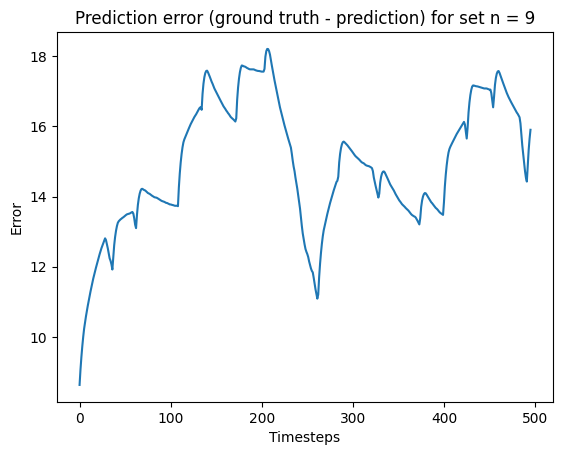

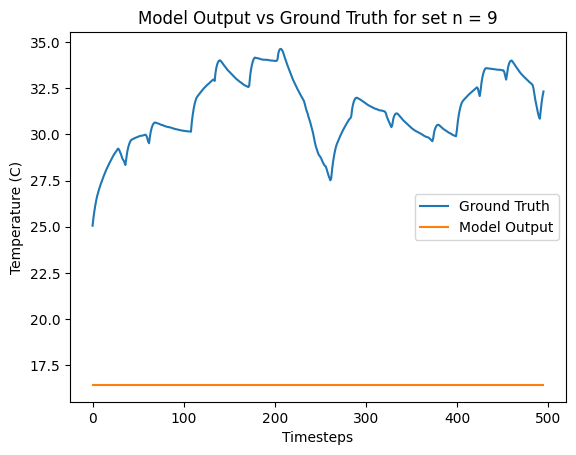

Epoch 2 | Epoch mean training loss for a single simulation = 2844.270012823807
Epoch 2 | Epoch mean test loss for a single simulation = 26.63296056943476


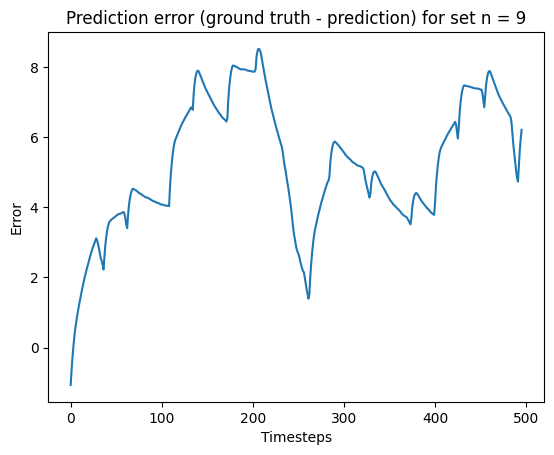

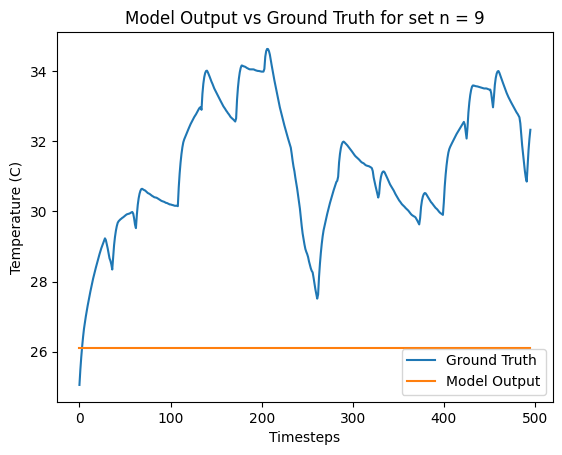

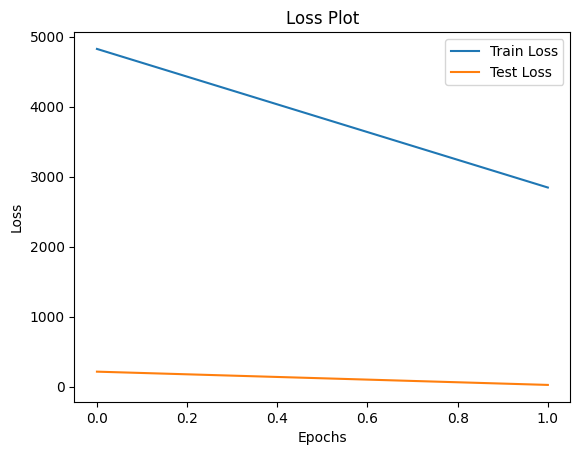

Time per epoch =  122.48039603233337
Total time =  244.96079206466675 sec
train_and_test finished


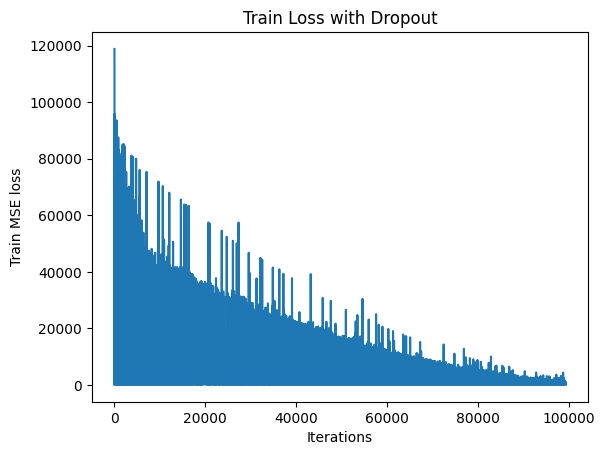

In [43]:

model = NeuralNet (num_hidden_layers = 3, hidden_size = 8, dropout_rate = 0.3, input_size = 8, output_size = 1)

# Train the NN
overall_test_loss_list_one_value_per_epoch, train_loss_list, elapsed_time = train_and_test(model, train_data, test_data, optimizer = "Adam", num_epochs = 2)

print ("="*50)
print ("train_and_test finished")
print ("="*50)

plt.figure ()
plt.plot (train_loss_list)
plt.title(f"Train Loss with Dropout")
plt.xlabel("Iterations")
plt.ylabel("Train MSE loss")
plt.show()


# torch.save(best_model.state_dict(), f"best_num_layers_{best_num_layers}.pth")

# SAVE:
# model (state dict)
# overall_test_loss_list_one_value_per_epoch (loss list)
# loss plots
# output plots

---
### Best model

- hidden size: 8

- number of layers: 3

- No dropout

- Dataset (from 100 ODE Solutions)
    - Features: $F_{ag}$ and $T_r$ at four previous timesteps
    - Label: $T_r$ at next time

In [44]:
# Load saved model
model = NeuralNet (num_hidden_layers = 3, hidden_size = 8, dropout_rate = 0.0, input_size = 8, output_size = 1)
model.load_state_dict (torch.load("best_model.pth"))
model.eval()

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.0, inplace=False)
  (5): Linear(in_features=8, out_features=8, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.0, inplace=False)
  (8): Linear(in_features=8, out_features=8, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.0, inplace=False)
  (11): Linear(in_features=8, out_features=1, bias=True)
)

In [58]:
prev_4_states

tensor([299.1488, 299.1479, 299.1553, 299.1575,   7.0000,   6.0000,   5.0000,
          2.0000], device='cuda:0')

In [64]:
predictions=[]
gt = []
for i, data in enumerate(test_data):
    prev_4_states = data[0, i, :-1].float().flatten().to(device)
    current_temp = data[0, i, -1].float().flatten().to(device)

    predicted_current_temp = model(prev_4_states) # (1,)
    
    gt.append (current_temp.item())
    predictions.append (predicted_current_temp.item())


In [69]:
gt

[297.8294982910156,
 301.03558349609375,
 295.40380859375,
 302.10821533203125,
 302.08428955078125,
 304.11907958984375,
 298.6634826660156,
 302.4458312988281,
 305.7367858886719,
 300.46044921875]

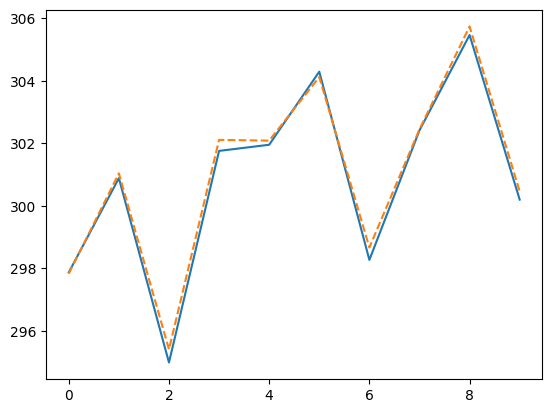

In [65]:
plt.plot (predictions)
plt.plot (gt,"--")

In [46]:
for i in model.parameters():
    print (i)

Parameter containing:
tensor([[ 0.0470,  0.0188, -0.1132, -0.0409, -0.2051, -0.3982, -0.0177, -0.0650],
        [-0.2041,  0.1977, -0.3289,  0.1481, -0.0225,  0.0218, -0.0724,  0.1770],
        [-0.0368, -0.1830, -0.2904,  0.2390, -0.1895,  0.0314, -0.0526,  0.0249],
        [-0.1120, -0.2605, -0.2497, -0.0944,  0.1391, -0.0166,  0.1982,  0.2166],
        [ 0.1201, -0.0844, -0.0244, -0.0229, -0.2013, -0.1524, -0.3954, -0.8583],
        [-0.0093, -0.0921,  0.0484, -0.2610, -0.0521, -0.1720, -0.2093,  0.1028],
        [ 0.7539,  1.1836,  0.9852,  0.9710,  0.0100,  0.0093,  0.0160,  0.0098],
        [-0.1698, -0.1760,  0.0469, -0.0149, -0.1059, -0.2312, -0.2392, -0.1273]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0489,  0.0646, -0.1379, -0.0960, -0.2097, -0.1585,  0.6805, -0.3561],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.5318, -0.3143, -0.1809,  0.1836, -0.1696, -0.1291, -0.4163,  0.1027],
        [ 0.0567,  0.0582,